In [51]:
# from lfs_tree import *
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import pydot
import networkx as nx
from string import Template
import pandas as pd
import glob
import pydot
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import seaborn as sns

from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib as mpl

# from IPython.display import Image, display
# Configure global font size settings
mpl.rcParams.update({
    'font.size': 25,  # Default font size for titles, labels, and tick labels
    'axes.labelsize': 20,  # Font size for axis labels
    'xtick.labelsize': 20,  # Font size for x-axis tick labels
    'ytick.labelsize': 20,  # Font size for y-axis tick labels
    'legend.fontsize': 20,  # Font size for the legend
    'legend.title_fontsize': 20  # Font size for the legend title

})


In [52]:
# functions

def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

def show_trees(directory):
    treefiles = glob.glob(f'{directory}*tree_*')
    num_trees_per_strat = len(treefiles)
    for i in range(0, int(num_trees_per_strat)):
        for f in glob.glob(f'{directory}*tree_*_{i}*'):
            file = open(f)
            dot_string = file.read()
            print(f)
#             print(dot_string)
            graph = pydot.graph_from_dot_data(dot_string)[0]
            view_pydot(graph)
            print('\n')
            
def show_stats(directory):
    fs = glob.glob(f'{directory}*/*experiment_stats')
    df = pd.concat([pd.read_csv(f) for f in fs])
    return df

def determine_shape(x, shape_assignment_dict):
    return shape_assignment_dict[x]

def determine_color(x, color_assignment_dict):
    return color_assignment_dict[x]

def scatter_plots(df, x, y, xlabel, ylabel, title, shape_assignment_dict, color_assignment_dict,
                 first_legend_pos, second_legend_pos, strat_legend_rel_pos, ratio_legend_re_pos):
        
    fig, ax = plt.subplots()
    groups = df.groupby(['strat','complaint_ratio'])
    # Create a scatter plot for each group based on shape and color
    for (strat, ratio), group in groups:
        marker = shape_assignment_dict.get(strat)
        color=color_assignment_dict.get(ratio)
        ax.scatter(group[x], group[y], marker=marker, color=color, label=(strat, ratio))

    # Create separate shape and color legends
    legend_elements_1 = []
    legend_elements_2 = []

    for shape, marker in shape_assignment_dict.items():
        legend_elements_1.append(plt.Line2D([0], [0], marker=marker, color='w', label=shape, markerfacecolor='k'))
    for ratio, color in color_assignment_dict.items():
        legend_elements_2.append(plt.Line2D([0], [0], marker='o', color='w', label=ratio, markerfacecolor=color))

    # Add shape and color legends
    first_legend=ax.legend(handles=legend_elements_1, loc=first_legend_pos, 
                           bbox_to_anchor=strat_legend_rel_pos,
                           title='strategy', 
                           fontsize=13,title_fontsize=14)
    ax.legend(handles=legend_elements_2, loc=second_legend_pos, 
              bbox_to_anchor=ratio_legend_re_pos, title='complaint%',
              fontsize=13, title_fontsize=14)

    ax.add_artist(first_legend)

    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=14)

    plt.show()
    plt.close(fig)
    

def scatter_plot_single_group_value(df, x, y, xlabel, ylabel, title, color_assignment_dict, group_col,
                                   scale, xticks=[], yticks=[]):
    fig, ax = plt.subplots()
    groups = df.groupby([group_col])
    for (g), group in groups:
        color = color_assignment_dict.get(g)
        ax.scatter(group[x], group[y], color=color, label=(g), s=10)  # Set linestyle to an empty string
    if(ylabel=='new_global_accuracy'):
        ax.plot(df[x], df['global_accuracy'], color='black', label='accuracy_before_fix')
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=14)
    ax.set_yscale(scale)  # Set the y-axis to logarithmic scale
    if(yticks):
        ax.set_yticks(yticks)
    if(xticks):
        ax.set_xticks(xticks)
    # Customize y-axis ticks and labels
#     ax.set_yticks([0.1, 1, 10, 100])
#     ax.set_yticklabels(['10^-1', '10^0', '10^1', '10^2'])
    ax.legend(fontsize=13,title_fontsize=14)
    plt.savefig(f'graph_pdfs/{title}.pdf', format='pdf')
    
    plt.show()
    plt.close(fig)
    plt.show()
    plt.close(fig)

    
def line_plots(df, x, y, xlabel, ylabel, title, color_assignment_dict, legend_pos,
#                group_name,
#                group_value, 
               gtype='general',
               ylim=None,
              ):
    fig, ax = plt.subplots()
#     df=df[df[group_name]==group_value]
    # Create a scatter plot for each group based on shape and color
    groups = df.groupby(['strat'])
    for strat, group in groups:
        color = color_assignment_dict.get(strat)
        print(f'color: ')
        ax.plot(group[x], group[y], color=color, label=strat)
    if(gtype=='accuracy'):
        ax.plot(df[x], df['global_accuracy'], color='blue', label='accuracy_before_fix')
    ax.legend()
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=14)
    if(ylim):
        ax.set_ylim(ylim)
    plt.savefig(f'graph_pdfs/{title}.pdf', format='pdf')
    plt.show()
    plt.close(fig)


def plot_stuff(df, x, y, xlabel, ylabel, title, yscale=[], xscale=[], yticks=[], xticks=[], ptype='bar'):
    plt.figure(figsize=(8, 6))
    
    # Set the y-axis scale
    dataset_list = list(df['table_name'].unique())
    dataset_list.sort()
    if(ptype=='bar'):
        ax = sns.barplot(data=df, x=x, y=y, hue='table_name', hue_order=dataset_list)
    elif(ptype=='box'):
        ax = sns.boxenplot(data=df, x=x, y=y, hue='table_name', hue_order=dataset_list)
        # Change tick label font size for both x and y axes
    ax.tick_params(axis='both')
    
    # Add a horizontal line at the specified y-coordinate (line_y)
    if ylabel == 'new_global_accuracy':
#     if line_y is not None:
        ax.axhline(y=float(df['global_accuracy'].unique()[0]), color='red', label='gloabl accuracy before fix',
                  linewidth=5)
        ax.legend()
        # Create a separate legend for the box plot (customize as needed)
        box_legend = ax.legend(title='Strat')
    
        # Combine the legends
        ax.add_artist(box_legend)
    else:
        # Create a separate legend for the box plot (customize as needed)
        ax.legend(title='dataset')
    if yscale:
        ax.set_yscale(yscale)
    
    if xscale:
        ax.set_xscale(xscale)
    
    if yticks:
        ax.set_yticks(yticks)
    
    if xticks:
        ax.set_xticks(xticks)

#     plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.savefig(f"graph_pdfs/scalability_{ptype}_{title}.pdf", format="pdf",bbox_inches='tight', pad_inches=0.2)
    plt.show()



In [53]:
# df_2_strats= show_stats('../experiment_results_folders/without_optimal/')
f = glob.glob('../experiment_results_folders/experiment_lf_scalability1011/*/*experiment_stats')
df = pd.concat([pd.read_csv(x) for x in f])

In [54]:
df.shape

(61, 27)

In [55]:
df

,strat,seed,table_name,rbbm_runtime,bbox_runtime,avg_tree_size_increase,user_input_size,complaint_ratio,num_complaints,num_confirmations,global_accuracy,fix_rate,confirm_preserve_rate,new_global_accuracy,prev_signaled_cnt,new_signaled_cnt,num_functions,deletion_factor,post_fix_num_funcs,num_of_funcs_processed_by_algo,complaint_reached_max,confirm_reached_max,lf_source,retrain_after_percent,retrain_accuracy_thresh,load_funcs_from_pickle,pre_deletion_threshold
0,information_gain,123,enron,1.031,83.173,0.800000,20,0.5,10,10,0.526,1.000,0.500,0.759,15366,15366,30,0.0,30,30,False,False,undefined,1,1,True,0.0
0,information_gain,123,amazon,0.107,308.604,0.533333,20,0.5,10,10,0.129,1.000,0.300,0.858,127796,127796,30,0.0,30,30,False,False,undefined,1,1,True,0.0
0,information_gain,123,youtube,0.056,4.369,0.533333,20,0.5,10,10,0.238,1.000,0.000,0.749,684,684,30,0.0,30,30,False,False,undefined,1,1,True,0.0
0,information_gain,123,enron,3.335,93.799,1.066667,40,0.5,20,20,0.526,0.950,0.650,0.798,15366,15366,30,0.0,30,30,False,False,undefined,1,1,True,0.0
0,information_gain,123,enron,1.605,108.079,0.800000,20,0.5,10,10,0.526,1.000,0.500,0.759,15366,15366,30,0.0,30,30,False,False,undefined,1,1,True,0.0
0,information_gain,123,amazon,0.106,329.598,0.533333,20,0.5,10,10,0.129,1.000,0.300,0.858,127796,127796,30,0.0,30,30,False,False,undefined,1,1,True,0.0
0,information_gain,123,amazon05,0.055,183.614,0.466667,20,0.5,10,10,0.354,0.900,0.100,0.653,68662,68662,30,0.0,30,30,False,False,undefined,1,1,True,0.0
0,information_gain,123,youtube,0.056,4.355,0.533333,20,0.5,10,10,0.238,1.000,0.000,0.749,684,684,30,0.0,30,30,False,False,undefined,1,1,True,0.0
0,information_gain,123,enron,3.320,85.197,1.066667,40,0.5,20,20,0.526,0.950,0.650,0.798,15366,15366,30,0.0,30,30,False,False,undefined,1,1,True,0.0
0,information_gain,123,amazon,0.362,317.205,1.000000,40,0.5,20,20,0.129,1.000,0.300,0.862,127796,127796,30,0.0,30,30,False,False,undefined,1,1,True,0.0


In [56]:
df.groupby(['table_name','user_input_size']).size()

table_name  user_input_size
amazon      20                 4
            40                 3
            80                 3
            160                3
            320                2
amazon05    20                 3
            40                 3
            80                 3
            160                3
            320                2
enron       20                 4
            40                 4
            80                 3
            160                3
            320                3
youtube     20                 4
            40                 3
            80                 3
            160                3
            320                2
dtype: int64

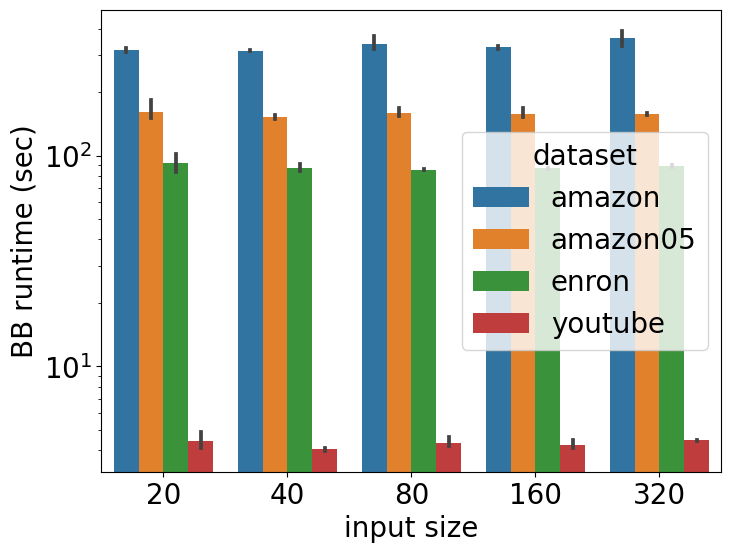

In [57]:
# for y in ['bbox_runtime', 'rbbm_runtime']:
plot_stuff(df=df, 
        x='user_input_size', 
        y='bbox_runtime', 
        xlabel='input size', 
        ylabel='BB runtime (sec)', 
        title=f'input_size vs bbox_runtime (LF)', 
        yscale='log',
       )


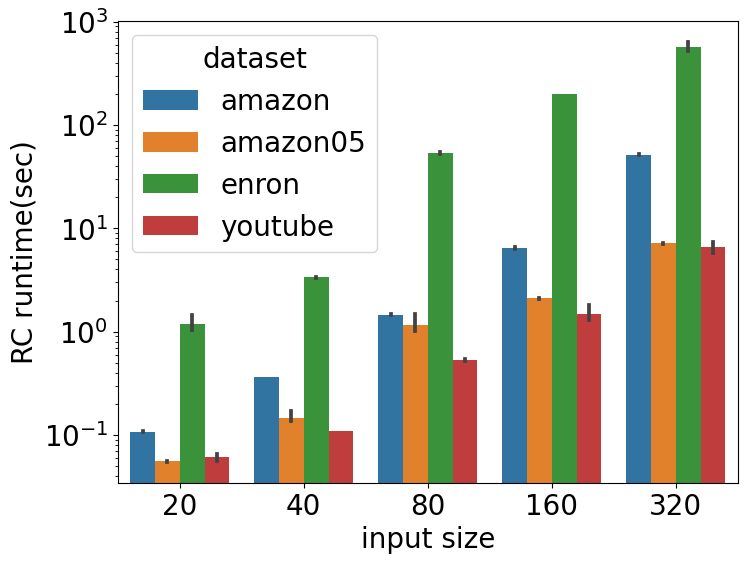

In [58]:
plot_stuff(df=df, 
        x='user_input_size', 
        y='rbbm_runtime', 
        xlabel='input size', 
        ylabel='RC runtime(sec)', 
        title=f'input_size vs RuleCleaner_runtime (LF)', 
        yscale='log',
       )